<a href="https://colab.research.google.com/github/anaguilarar/MT_elements/blob/main/Multi-Target%20prediction%20for%20element%20concentration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
## clonning repositories
if not os.path.exists("/content/MT_elements") and not os.getcwd().endswith("/content/MT_elements"):
    !git clone https://github.com/anaguilarar/MT_elements.git
    print("Cloned")
    os.chdir("/content/MT_elements")
    
else:
    print("MT_elements directory already exists")
    os.chdir("/content/MT_elements")



MT_elements directory already exists


In [1]:
import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from element_prediction.models.chain_mlfunctions import *
from element_prediction.utils.data_processing import *
from element_prediction.hsi.sp_functions import SpectralData
from element_prediction.utils.reporters import MT_ElementReporter,regressionReporter
from element_prediction.utils.osc_preprocessing import OSC
from configuration import Configuration

c:\Users\aguilar\miniconda3\envs\spectral_data\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Element concentration prediction using multi-target regression

The present repository is intended to document the element concentration prediction using a multi-target regression method based on Regressor Chain.
Although many studies have successfully predicted the element concentration prediction using hyperspectral imaging (HSI), here we presented an alternative that besides using HSI, we also included the inter-target dependency as input features.
To determine the effectiveness of applying multi-target (MT) compared with single-target (ST) regression, we predict the concentration values for 17 elements using both methods, and their prediction accuracy was compared.
This notebook is divided into four sections: 
- Spectral data processing
- Single-target regression
- Multi-target regression
- Results comparison.

#### Spectral data processing

The hyperspectral information was first pre-processed in R, where the data was subjected to an outlier removal process, followed by standardisation.
In this step we read the data saved as a CSV file, where the rows are the observations and the columns are the wavelength values.
Before starting, please modify the conguration.py file, to update the directory paths.

Index(['B', 'Ca43', 'Cd', 'Co', 'Cu', 'Fe', 'K', 'Li', 'Mg', 'Mn', 'Mo', 'Na',
       'P', 'Rb', 'S', 'Sr', 'Zn'],
      dtype='object')
[18.32512372 17.33393033 26.22556242 27.99944379 22.76879536]
90.00088224351477


Text(0.5, 1.0, 'Direct orthogonal signal correction \n(DOSC) using B as target')

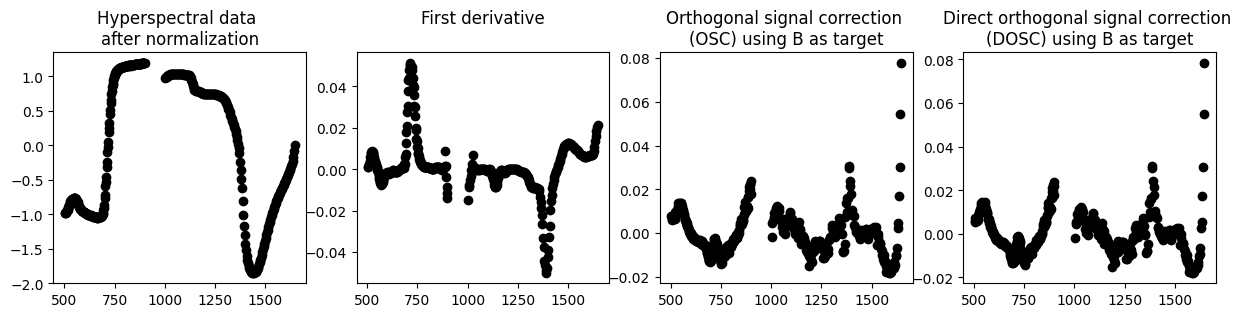

In [29]:
import matplotlib.pyplot as plt

## folders
sp_path = Configuration.sp_path
nut_values_path = Configuration.target_path


spdata = SpectralData(sp_path, columns_suffix = 'WL.', apply_sg = True)

elementsdata = ElementsData(nut_values_path)
print(elementsdata.data.columns)
bval = elementsdata.data['B'].values
print(bval[:5])
spd = spdata.data.reset_index().drop(['index'], axis = 1).values.copy()

## getting osc

osccorrect = OSC(n_components=10, n_osccomponents = 2, 
                 method = 'osc_wold', 
                 plsregression = 'simpls',
                 scalex = False, scaley = True)
osccorrect.fit(spd, bval)
print(osccorrect.angle(bval))
xcosc = osccorrect.transform(spd.copy())

## getting dosc 

dosccorrect = OSC(n_osccomponents = 2, 
                 method = 'dosc', 
                 scalex = False, scaley = True)

dosccorrect.fit(spd, bval)
xcdosc = dosccorrect.transform(spd.copy())

f, ax = plt.subplots(nrows=1, ncols=4, figsize = [15,3])

ax[0].scatter(spdata.wavelengths,spdata.data.iloc[0].values, c= 'black')
ax[0].set_title('Hyperspectral data \nafter normalization')
#ax[1].scatter(spdata.wavelengths,spdata.data_sg.iloc[0].values)
#ax[1].set_title('Hyperspectral data after Savitsky-Golay')
ax[1].scatter(spdata.wavelengths[2:],spdata.first_derivative.iloc[0].values, c= 'black')
ax[1].set_title('First derivative\n')

ax[2].scatter(spdata.wavelengths[0:],xcosc[0], c= 'black')
ax[2].set_title('Orthogonal signal correction \n(OSC) using B as target')

ax[3].scatter(spdata.wavelengths[0:],xcdosc[0], c= 'black')
ax[3].set_title('Direct orthogonal signal correction \n(DOSC) using B as target')


In [3]:
sppre = spdata.data_sg.copy()
sppre.columns = ['wl_{}'.format(sp) for sp in spdata.wavelengths]
sppre.to_csv("preprocessingdata.csv")

fddata = spdata.first_derivative.copy()
fddata.columns = ['wl_{}'.format(sp) for sp in spdata.wavelengths[2:]]
fddata.to_csv("first_derivative.csv")

### Data splitting

To train and validate the machine learning models, we divided the dataset into two datasets. One for training (90%) and another one for testing (10%). Besides the training dataset is split into 10-folds for cross-validations. The cross-validation results will be used to determine if there is a significance improvement when the models are trained with MT regression.


In [30]:
idtestvalues = [240, 381, 147,  65, 677, 721,  24, 356, 424, 667, 732,  33, 483,
       669, 330,  29, 413, 559, 663, 716, 548,   8, 443, 671, 655, 363,
       675,  64, 111,   0, 430, 708, 278, 651, 262, 705, 197, 662, 137,
        10,  45, 472, 387, 455, 733, 157, 181, 495, 557, 238, 506, 294,
        61, 513, 544, 415, 234, 360,  13, 372, 643,  90, 600, 193,  16,
       344, 586, 396, 467,  75, 400, 567, 726, 342]


idsfun = SplitIds(spdata.first_derivative.reset_index().shape[0],val_perc =None,
                  seed = 123, shuffle = True, testids_fixed = idtestvalues)


### Single-target and Multi-target regression

Now that we have the element concentration and hyperspectral data, we predict the elements values. To do that we emplyd a function called ElementschainRegressor, which will give first predict a target using single-target moldes the will add individual target prediction until there is not an improvemeent. These results will be used as a reference to determine whether an improvement was achieved.

This is done for each nutrient and regressor model

In [37]:
streporter  = regressionReporter(_reporter_keys=['id','chain','model','r2', 'rmse', 'prmse', 'mae', 'cv'])


#### Single-target

##### using Savitsly golay as preprocessing method

In [6]:
conf = Configuration()

for modelname in conf.modelnames:
        st_reporter_output = os.path.join(Configuration.reporterspath,'st_spectral_results_{}.json'.format(modelname))
        streporter.reset_reporter()
        for element in conf.elements:
                
                testrc = ElementsChainRegressor(base_estimator=set_model(modelname, nworkers = -1,scaler ='minmax'),
                                                spdata = spdata.data_sg.reset_index().drop(['index'], axis = 1),
                                                elements_concentration = ElementsData(nut_values_path),
                                                random_state=42,
                                                ids_order = idsfun)

                ## get cv results
                testrc.cv_sinle_output_fit(element_to_fit=element,kfolds=10)
                pred = testrc.cv_single_output_prediction()
                m = testrc.cv_single_output_validation(pred)

                ## save reporter
                results = {i:list(pd.concat(m)[i].values.astype(float)) 
                        if pd.concat(m)[i].values.dtype == np.int64 
                        else list(pd.concat(m)[i].values) for i in pd.concat(m).columns}
                results.update({'id':element, 'chain':element, 'model':modelname}) 
                streporter.update_reporter(results)

                ## printing
                r2ref = pd.concat(m).r2.mean()
                print('{} {} R squared: {:.3f}'.format(modelname,element, r2ref))
                
        streporter.save_reporter(st_reporter_output)
                

ridge Li R squared: 0.636
ridge B R squared: 0.495
ridge Na R squared: 0.606
ridge Mg R squared: 0.747
ridge P R squared: 0.651
ridge S R squared: 0.573
ridge K R squared: 0.550
ridge Ca43 R squared: 0.719
ridge Mn R squared: 0.668
ridge Fe R squared: 0.527
ridge Co R squared: 0.596
ridge Cu R squared: 0.550
ridge Zn R squared: 0.581
ridge Rb R squared: 0.708
ridge Sr R squared: 0.702
ridge Mo R squared: 0.733
ridge Cd R squared: 0.409
lasso Li R squared: 0.620
lasso B R squared: 0.495
lasso Na R squared: 0.594
lasso Mg R squared: 0.718
lasso P R squared: 0.612
lasso S R squared: 0.559
lasso K R squared: 0.523
lasso Ca43 R squared: 0.696
lasso Mn R squared: 0.663
lasso Fe R squared: 0.517
lasso Co R squared: 0.551
lasso Cu R squared: 0.508
lasso Zn R squared: 0.567
lasso Rb R squared: 0.671
lasso Sr R squared: 0.686
lasso Mo R squared: 0.711
lasso Cd R squared: 0.372
pls Li R squared: 0.613
pls B R squared: 0.477
pls Na R squared: 0.582
pls Mg R squared: 0.714
pls P R squared: 0.618
pl

##### using osc and dosc as preprocessing methods

In [38]:
conf = Configuration()

for modelname in conf.modelnames:
        osc_reporter_output = os.path.join(Configuration.reporterspath,'osc_spectral_results_{}.json'.format(modelname))
        streporter.reset_reporter()
        for element in conf.elements:
                spd = spdata.data_sg.reset_index().drop(['index'], axis = 1).copy()
                elementdata = ElementsData(nut_values_path)
                ecval  = elementdata.data[element].values
                
                osccorrect = OSC(n_components=10, n_osccomponents = 2, method = 'osc_wold', 
                                plsregression = 'simpls', scalex = False, scaley = True)
                osccorrect.fit(spd, ecval)
                print(osccorrect.angle(ecval))
                xcosc = osccorrect.transform(spd.copy())

                testrc = ElementsChainRegressor(base_estimator=set_model(modelname, nworkers = -1,scaler ='minmax'),
                                                spdata = pd.DataFrame(xcosc),
                                                elements_concentration = ElementsData(nut_values_path),
                                                random_state=42,
                                                ids_order = idsfun)

                ## get cv results
                testrc.cv_sinle_output_fit(element_to_fit=element,kfolds=10)
                pred = testrc.cv_single_output_prediction()
                m = testrc.cv_single_output_validation(pred)

                ## save reporter
                results = {i:list(pd.concat(m)[i].values.astype(float)) 
                        if pd.concat(m)[i].values.dtype == np.int64 
                        else list(pd.concat(m)[i].values) for i in pd.concat(m).columns}
                results.update({'id':element, 'chain':element, 'model':modelname}) 
                streporter.update_reporter(results)

                ## printing
                r2ref = pd.concat(m).r2.mean()
                print('{} {} R squared: {:.3f}'.format(modelname,element, r2ref))
                
        streporter.save_reporter(osc_reporter_output)

90.00258491486485
ridge Li R squared: 0.595
90.00083135258433
ridge B R squared: 0.507
89.99858648721835
ridge Na R squared: 0.594
90.00100478341453
ridge Mg R squared: 0.747
89.9998369235425
ridge P R squared: 0.672
90.00249201765745
ridge S R squared: 0.504
90.00136697069114
ridge K R squared: 0.536
90.00053480010472
ridge Ca43 R squared: 0.727
90.00236257110313
ridge Mn R squared: 0.629
90.00182734776472
ridge Fe R squared: 0.491
90.00295381173996
ridge Co R squared: 0.484
89.99993371501844
ridge Cu R squared: 0.567
89.99759260959837
ridge Zn R squared: 0.561
90.00188533534518
ridge Rb R squared: 0.681
89.99987467196061
ridge Sr R squared: 0.708
90.00204548757104
ridge Mo R squared: 0.672
90.00024758138849
ridge Cd R squared: 0.419
90.00258491486485
lasso Li R squared: 0.583
90.00083135258433
lasso B R squared: 0.505
89.99858648721835
lasso Na R squared: 0.588
90.00100478341453
lasso Mg R squared: 0.738
89.9998369235425
lasso P R squared: 0.653
90.00249201765745
lasso S R squared: 0

In [ ]:
conf = Configuration()
streporter  = regressionReporter(_reporter_keys=['id','chain','model','r2', 'rmse', 'prmse', 'mae', 'cv'])

for modelname in conf.modelnames:
        osc_reporter_output = os.path.join(Configuration.reporterspath,'dosc_spectral_results_{}.json'.format(modelname))
        streporter.reset_reporter()
        for element in conf.elements:
                spd = spdata.data_sg.reset_index().drop(['index'], axis = 1).copy()
                elementdata = ElementsData(nut_values_path)
                ecval  = elementdata.data[element].values
                
                osccorrect = OSC(n_osccomponents = 2, method = 'dosc', 
                                scalex = False, scaley = True)
                osccorrect.fit(spd, ecval)
                
                xcosc = osccorrect.transform(spd.copy())

                testrc = ElementsChainRegressor(base_estimator=set_model(modelname, nworkers = -1,scaler ='minmax'),
                                                spdata = pd.DataFrame(xcosc),
                                                elements_concentration = ElementsData(nut_values_path),
                                                random_state=42,
                                                ids_order = idsfun)

                ## get cv results
                testrc.cv_sinle_output_fit(element_to_fit=element,kfolds=10)
                pred = testrc.cv_single_output_prediction()
                m = testrc.cv_single_output_validation(pred)

                ## save reporter
                results = {i:list(pd.concat(m)[i].values.astype(float)) 
                        if pd.concat(m)[i].values.dtype == np.int64 
                        else list(pd.concat(m)[i].values) for i in pd.concat(m).columns}
                results.update({'id':element, 'chain':element, 'model':modelname}) 
                streporter.update_reporter(results)

                ## printing
                r2ref = pd.concat(m).r2.mean()
                print('{} {} R squared: {:.3f}'.format(modelname,element, r2ref))
                
        streporter.save_reporter(osc_reporter_output)

#### Multi-target

In [6]:
## reporter: this class will store the prediction results per model
mtreporter  = MT_ElementReporter(_reporter_keys=['id', 'chain', 'r2', 'rmse', 'prmse', 'mae', 'cv'])


In [7]:
mtreporter.get_chain_results(chain='Mg', 
                             acc_score=['r2','rmse','prmse','mae', 'cv']) 

-1

In [8]:

conf = Configuration()

for modelname in conf.modelnames:
    mt_reporter_output = os.path.join(Configuration.reporterspath,'mt_spectral_results_{}.json'.format(modelname))
    if os.path.exists(mt_reporter_output):
        mtreporter.load_reporter(mt_reporter_output)
    else:
        mtreporter.reset_reporter()
        
    mtreporter.fn = mt_reporter_output
    for element_to_predict in conf.elements:

        testrc = ElementsChainRegressor(base_estimator=set_model(modelname, nworkers = -1,scaler ='minmax'),
                                            spdata = spdata.data_sg.reset_index().drop(['index'], axis = 1),
                                            elements_concentration = ElementsData(nut_values_path),
                                            random_state=42,
                                            ids_order = idsfun)
        
        final_chain, performances = testrc.find_best_chain(element_to_predict,
                                                           kfolds=10, 
                                                           not_include = ['Cd','K', 'B','Fe','Zn'], 
                                                           reporter= mtreporter)

initial elements  ['B', 'Ca43', 'Cd', 'Co', 'Cu', 'Fe', 'K', 'Mg', 'Mn', 'Mo', 'Na', 'P', 'Rb', 'S', 'Sr', 'Zn']
Li: reference accuracy: 0.636
chain Ca43_Li perfomance: 0.638
chain Co_Li perfomance: 0.642
chain Cu_Li perfomance: 0.642
chain Mg_Li perfomance: 0.644
chain Mn_Li perfomance: 0.637
chain Mo_Li perfomance: 0.639
chain Na_Li perfomance: 0.636
chain P_Li perfomance: 0.640
chain Rb_Li perfomance: 0.640
chain S_Li perfomance: 0.636
chain Sr_Li perfomance: 0.634
the chain was updated : Mg_Li
remaining elements  ['Ca43', 'Co', 'Cu', 'Mn', 'Mo', 'Na', 'P', 'Rb', 'S', 'Sr']
chain Ca43_Mg_Li perfomance: 0.638
chain Co_Mg_Li perfomance: 0.642
chain Cu_Mg_Li perfomance: 0.644
chain Mn_Mg_Li perfomance: 0.638
chain Mo_Mg_Li perfomance: 0.639
chain Na_Mg_Li perfomance: 0.639
chain P_Mg_Li perfomance: 0.641
chain Rb_Mg_Li perfomance: 0.643
chain S_Mg_Li perfomance: 0.636
chain Sr_Mg_Li perfomance: 0.633
the chain was updated : Cu_Mg_Li
remaining elements  ['Ca43', 'Co', 'Mn', 'Mo', 'Na', 

### Results

In this step we will obtian the single target and multi target regression results from the reporters.

In [ ]:
streporter  = MT_ElementReporter(_reporter_keys=['id','chain','r2', 'rmse', 'prmse', 'mae', 'cv'])
### single target results 
stresultspermodel = []
for modelname in Configuration.modelnames:
    reporter_path = os.path.join(Configuration.reporterspath,'st_results_{}.json'.format(modelname))
    streporter.load_reporter(reporter_path)
    stresultsperelement = []
    for eoi in tqdm.tqdm(Configuration.elements):
        results = pd.DataFrame(streporter.singletarget_results(eoi, acc_score=['r2', 'rmse', 'prmse', 'mae', 'cv']))
        results =pd.DataFrame(results)
        results['chain'] = eoi
        results['element'] = eoi
        stresultsperelement.append(results)
    dfst = pd.concat(stresultsperelement)
    dfst['model'] = modelname
    stresultspermodel.append(dfst)

load


100%|██████████| 17/17 [00:00<00:00, 1545.90it/s]


load


100%|██████████| 17/17 [00:00<00:00, 1416.52it/s]


load


100%|██████████| 17/17 [00:00<00:00, 1545.40it/s]


load


100%|██████████| 17/17 [00:00<00:00, 1214.31it/s]


load


100%|██████████| 17/17 [00:00<00:00, 1416.85it/s]


In [ ]:
## export file
pd.concat(stresultspermodel).to_csv(os.path.join(Configuration.reporterspath, 'st_results.csv'))

In [ ]:
streporter  = MT_ElementReporter(_reporter_keys=['id','chain','r2', 'rmse', 'prmse', 'mae', 'cv'])

### Multi-target target results 
mtresultspermodel = []
for modelname in Configuration.modelnames:
    reporter_path = os.path.join(Configuration.reporterspath,'mt_results_{}.json'.format(modelname))
    mtreporter.load_reporter(reporter_path)
    mtresultsperelement = []
    for eoi in tqdm.tqdm(Configuration.elements):
        # find the best result for a specific element
        chain, results = mtreporter.multitarget_results(element= eoi)
        pdr = pd.DataFrame(results)
        pdr['chain'] = chain
        pdr['element'] = eoi
        mtresultsperelement.append(pdr)
            
    dfmt = pd.concat(mtresultsperelement)
    dfmt['model'] = modelname
    mtresultspermodel.append(dfmt)
    
pd.concat(mtresultspermodel).to_csv(os.path.join(Configuration.reporterspath, 'mt_results.csv'))


load


100%|██████████| 17/17 [02:14<00:00,  7.94s/it]


load


100%|██████████| 17/17 [04:33<00:00, 16.11s/it]


load


100%|██████████| 17/17 [02:36<00:00,  9.20s/it]


load


100%|██████████| 17/17 [05:14<00:00, 18.48s/it]


load


100%|██████████| 17/17 [04:28<00:00, 15.82s/it]


### Element concentration prediction using test dataset

Finally, once we have found which elements had a significant improvement in their accuracy prediction (this step was done in R, please check the code "r_scripts/figures.R"). We train the multi-target and single-target regression using the test dataset.

In [9]:
from sklearn.metrics import r2_score
import pickle
   

Element Mg Multi-target: model rf chain Cu_P_Mg
training: 668 elements Index(['Cu', 'P', 'Mg'], dtype='object')


ElementsChainRegressor(base_estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                ('rf',
                 GridSearchCV(cv=3,
                              estimator=RandomForestRegressor(random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [4, 8, 16],
                                          'max_features': [0.15, 0.3, 0.4],
                                          'max_samples': [0.7, 0.9],
                                          'min_samples_split': [2, 4],
                                          'n_estimators': [200]}))]),
                       elements_concentration=None, ids_order=None,
                       random_state=42, spdata=None)

In [45]:
## elements with significance difference: 
eois = ["Mg", "P", "S", "Mn", "Fe", "Co", "Cu", "Sr", "Mo", "Cd"]

stresults = pd.read_csv(os.path.join(Configuration.reporterspath, 'st_results.csv'))
mtresults = pd.read_csv(os.path.join(Configuration.reporterspath, 'mt_results.csv'))

allresults = []
for eoi in eois:

    ## singletarget

    eoidf = stresults.loc[stresults.element == eoi]
    bestmodel_st = eoidf.groupby(['model']).mean('r2').sort_values(by=['r2'], ascending=False).reset_index(
        ).model.values[0]

    ## multitarget
    eoidf = mtresults.loc[mtresults.element == eoi]
    bestmodel_mt = eoidf.groupby(['model']).mean('r2').sort_values(by=['r2'], ascending=False).reset_index().model.values[0]
    bestmodel_mt= 'rf'
    chain = eoidf.loc[eoidf.model == bestmodel_mt].chain.values[0]

    ## MlT prediction

    print('Element {} Multi-target: model {} chain {}'.format(eoi, bestmodel_mt, chain))
    testrc = ElementsChainRegressor(base_estimator=set_model(bestmodel_mt, nworkers = -1,scaler ='minmax'),
                                    spdata = spdata.first_derivative.reset_index().drop(['index'], axis = 1),
                                    elements_concentration = ElementsData(nut_values_path),
                                    random_state=42,
                                    ids_order = idsfun)

    ## multi-target prediction
    testrc.fit_chain(chain = chain)

    ## mt results
    elementsdata = testrc.element_concentrations.data_elements(chain.split('_'))
    tra_x, tra_y, val_x, val_y = get_xyvaldata(testrc.features, elementsdata, phase="validation", split_ids = testrc.split_ids)
    y_predmulti = testrc.predict(val_x.to_numpy())[:,len(chain.split('_'))-1]
    ## data
    
    multiresults = pd.DataFrame({'real': val_y.values[:,len(chain.split('_'))-1].ravel(),'pred': y_predmulti,'regressortype': 'multi_target' })
    multiresults['chain'] = chain
    multiresults['model'] = bestmodel_mt

    r2mt = r2_score(
        y_true=multiresults.real.values,
        y_pred=multiresults.pred.values)
    
    modelname = 'ml_weights/MTSC_{}_chain_{}_model_{}.pickle'.format(eoi,chain,bestmodel_mt)
    with open(modelname, 'wb') as fn:
        pickle.dump(testrc, fn)
    
    ## single-target prediction
    print('Element {} Single-target: model {}'.format(eoi, bestmodel_st, chain))
    sgmodel = set_model(bestmodel_st, nworkers = -1,scaler ='minmax')
    elementsdata = testrc.element_concentrations.data_elements([eoi])

    tra_x, tra_y, val_x, val_y = get_xyvaldata(testrc.features, 
                                            elementsdata, phase="validation", 
                                            split_ids = testrc.split_ids)

    sgmodel.fit(tra_x.to_numpy(), tra_y.to_numpy().ravel())
    y_pred_single = sgmodel.predict(val_x.to_numpy())
    
    singleresults = pd.DataFrame({'real': val_y.values.ravel(),'pred': y_pred_single,'regressortype': 'single_target' })
    singleresults['chain'] = chain.split('_')[-1]
    singleresults['model'] = bestmodel_st


    r2st = r2_score(
        y_true=singleresults.real.values,
        y_pred=singleresults.pred.values)

    print('Element: {}  ST r2 : {:.3f}  MT r2 {:.3f}'.format(eoi,r2st,r2mt))

    output = pd.concat([singleresults,multiresults])

    output['element'] = chain.split('_')[-1]

    allresults.append(output)


Element Mg Multi-target: model rf chain Cu_P_Mg
training: 668 elements Index(['Cu', 'P', 'Mg'], dtype='object')
Element Mg Single-target: model rf
Element: Mg  ST r2 : 0.833  MT r2 0.900
Element P Multi-target: model rf chain S_Rb_Cu_Mo_P
training: 668 elements Index(['S', 'Rb', 'Cu', 'Mo', 'P'], dtype='object')
Element P Single-target: model rf
Element: P  ST r2 : 0.731  MT r2 0.770
Element S Multi-target: model rf chain Co_Mg_Rb_Cu_Mo_S
training: 668 elements Index(['Co', 'Mg', 'Rb', 'Cu', 'Mo', 'S'], dtype='object')
Element S Single-target: model rf
Element: S  ST r2 : 0.643  MT r2 0.667
Element Mn Multi-target: model rf chain Na_Rb_Cu_Co_Mn
training: 668 elements Index(['Na', 'Rb', 'Cu', 'Co', 'Mn'], dtype='object')
Element Mn Single-target: model ridge
Element: Mn  ST r2 : 0.639  MT r2 0.716
Element Fe Multi-target: model rf chain Rb_Cu_Fe
training: 668 elements Index(['Rb', 'Cu', 'Fe'], dtype='object')
Element Fe Single-target: model svr_linear
Element: Fe  ST r2 : 0.596  MT r2 0

In [ ]:
pd.concat(allresults).to_csv(os.path.join(Configuration.reporterspath, 'test_results.csv'))

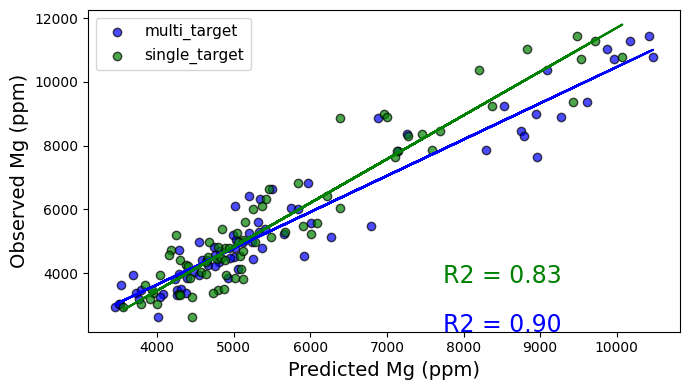

In [ ]:
### plot a single example
dftestresults = pd.read_csv(os.path.join(Configuration.reporterspath, 'test_results.csv'))

fig, ax = plt.subplots(figsize=(7, 4))
eoi = 'Mg'

res = pd.concat(allresults).loc[pd.concat(allresults).element == eoi]
cols = ['blue','green']

for i in range(len(np.unique(res.regressortype.values))):
    regs = np.unique(res.regressortype.values)[i]
    rval = res.loc[res.regressortype == regs]
    m, b = np.polyfit(rval.pred.values.ravel(), rval.real.values.ravel(), 1)
    
    #ax.plot(y_pred_single, val_y.values.ravel(), color='k', label='Regression model')
    ax.scatter(rval.pred.values.ravel(), rval.real.values.ravel(), edgecolor='k', facecolor=cols[i], 
               alpha=0.7, label=regs)
    ax.set_ylabel('Observed {} (ppm)'.format(rval.element.values[0]), fontsize=14)
    ax.set_xlabel('Predicted {} (ppm)'.format(rval.element.values[0]), fontsize=14)
    ax.plot(rval.pred.values.ravel(), m*rval.pred.values.ravel()+b, color=cols[i])
    ax.legend(facecolor='white', fontsize=11)
    r2st = r2_score(
        y_true=rval.real.values,
        y_pred=rval.pred.values)
    
    ax.text(0.6, 0.15*i, 'R2 = %.2f' % (r2st), fontsize=17, transform=ax.transAxes, color = cols[i])

fig.tight_layout()


### Comparison with only linear correlation

In [15]:
## reporter: this class will store the prediction results per model
mtreporter  = MT_ElementReporter(_reporter_keys=['id', 'chain', 'r2', 'rmse', 'prmse', 'mae', 'cv'])
modelname = "rf"

reporter_path = os.path.join(Configuration.reporterspath,'corr_mt_results_{}.json'.format(modelname))
if os.path.exists(reporter_path):
    mtreporter.load_reporter(reporter_path)
else:
    mtreporter.reset_reporter()

mtreporter.fn = reporter_path



testrc = ElementsChainRegressor(base_estimator=set_model(modelname, nworkers = -1,scaler ='minmax'),
                                            spdata = spdata.first_derivative.reset_index().drop(['index'], axis = 1),
                                            elements_concentration = ElementsData(nut_values_path),
                                            random_state=42,
                                            ids_order = idsfun)

element_to_predict = "Fe"


final_chain, performances = testrc.find_best_chain(element_to_predict,
                                                           kfolds=10, 
                                                           not_include = ['Cd','K', 'B','Fe','Zn','Na','Rb','Sr','S','Mg','Ca43','Li'], 
                                                           reporter= mtreporter,
                                                           chain = 'Cu_Co_Fe')


initial elements  ['B', 'Ca43', 'Cd', 'K', 'Li', 'Mg', 'Mn', 'Mo', 'Na', 'P', 'Rb', 'S', 'Sr', 'Zn']
chain Mn_Cu_Co_Fe perfomance: 0.559
chain Mo_Cu_Co_Fe perfomance: 0.598
chain P_Cu_Co_Fe perfomance: 0.605
the chain was updated : P_Cu_Co_Fe
remaining elements  ['Mn', 'Mo']
